In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import plotly.graph_objects as go
import plotly.express as px
import mlflow.sklearn
import mlflow.xgboost
import xgboost as xgb
import optuna
import os

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sksurv.metrics import concordance_index_censored

/home/joelt/miniconda3/envs/projet-business/lib/python3.9/site-packages/google/auth/__init__.py:54: FutureWarning: You are using a Python version 3.9 past its end of life. Google will update google-auth with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade your Python version, and then update google-auth.
  warnings.warn(eol_message.format("3.9"), FutureWarning)
/home/joelt/miniconda3/envs/projet-business/lib/python3.9/site-packages/google/oauth2/__init__.py:40: FutureWarning: You are using a Python version 3.9 past its end of life. Google will update google-auth with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade your Python version, and then update google-auth.
  warnings.warn(eol_message.format("3.9"), FutureWarning)
/home/joelt/miniconda3/envs/projet-business/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See h

#### Test GPU

In [2]:
# Test GPU par XGBoost
try:
    # On crée une micro-matrice de test
    data = xgb.DMatrix([[1, 2], [3, 4]], label=[1, 0])

    params = {'tree_method': 'gpu_hist', 'device': 'cuda'}
    xgb.train(params, data, num_boost_round=1)
    print("✅ Succès ! La RTX 4060 est reconnue et configurée.")
except Exception as e:
    print(f"❌ Échec du GPU : {e}")
    print("Le modèle tournera sur CPU par défaut.")

/home/joelt/miniconda3/envs/projet-business/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:43:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


✅ Succès ! La RTX 4060 est reconnue et configurée.


#### Import dataset

In [3]:
df = pd.read_parquet('dataset_full.parquet')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', '{:.4f}'.format)

print(f"Structure du dataset : {df.shape[0]} lignes et {df.shape[1]} colonnes")
display(df.head())

Structure du dataset : 1202455 lignes et 17 colonnes


,SIREN,Code postal de l'établissement,Code commune de l'établissement,Dénomination de l'unité légale,Catégorie juridique de l'unité légale,Activité principale de l'unité légale,Economie sociale et solidaire unité légale,Code du département de l'établissement,Code de la région de l'établissement,Date_fermeture_finale,Tranche_effectif_num,age_estime,latitude,longitude,code_ape,libelle_section_ape,fermeture
0,912239670,26740,26191,LES TOITURES PERENNES,5499,43.91A,N,26,84,2025-12-31,3,4,44.5480,4.7964,43,Travaux de construction spécialisés,0
1,389091893,91270,91657,OCB,5499,43.99C,N,91,11,2025-12-31,10,33,48.7156,2.4344,43,Travaux de construction spécialisés,0
2,888366747,30310,30344,COMME UN DIADEME,5710,47.91A,N,30,76,2025-12-31,1,5,43.7432,4.2062,47,"Commerce de détail, à l’exception des automobi...",0
3,953937455,75008,75108,WE CLEAN HOLDING PARNASSA,5710,66.30Z,N,75,11,2025-12-31,0,2,48.8731,2.3166,66,Activités auxiliaires de services financiers e...,0
4,840236111,94440,94070,LEVIO,5710,96.02A,N,94,11,2025-12-31,1,8,48.7283,2.5747,96,Autres services personnels,0


##### Préparation dataset pour modèle

In [4]:
# 1. NETTOYAGE GÉOGRAPHIQUE & RISQUE DÉPARTEMENTAL

df['Code du département de l\'établissement'] = df['Code du département de l\'établissement'].astype(str).str.zfill(2)

dep_risk_map = df.groupby("Code du département de l'établissement")["fermeture"].mean()
df['risque_departemental'] = df['Code du département de l\'établissement'].map(dep_risk_map)

# 2. TRAITEMENT DES TYPES (Catégories et Nullables)

df['Catégorie juridique de l\'unité légale'] = df['Catégorie juridique de l\'unité légale'].astype(str)


df['age_estime'] = df['age_estime'].astype(float)
df['Tranche_effectif_num'] = df['Tranche_effectif_num'].fillna(0).astype(float)

# 3. ENCODAGE DES VARIABLES

df['is_ess'] = df['Economie sociale et solidaire unité légale'].map({'O': 1, 'N': 0}).fillna(0)

# B. One-Hot Encoding : Secteurs APE et Catégories Juridiques

df_final = pd.get_dummies(
    df, 
    columns=['libelle_section_ape', 'Catégorie juridique de l\'unité légale'], 
    prefix=['APE', 'CJ'],
    drop_first=True
)

# 4. SÉLECTION FINALE ET NETTOYAGE DES COLONNES INUTILES
cols_to_drop = [
    'SIREN', 'Code postal de l\'établissement', 'Code commune de l\'établissement',
    'Dénomination de l\'unité légale', 'Activité principale de l\'unité légale',
    'Date_fermeture_finale', 'latitude', 'longitude', 'code_ape',
    'Code du département de l\'établissement', 'Code de la région de l\'établissement',
    'Economie sociale et solidaire unité légale'
]

df_final = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns])

# 5. DERNIERS RÉGLAGES POUR LA SURVIE

df_final['fermeture'] = df_final['fermeture'].astype(bool)

df_final = df_final[df_final['age_estime'] > 0]

print(f"✅ Dataset finalisé : {df_final.shape[0]} lignes, {df_final.shape[1]} colonnes.")
display(df_final.head(10))

✅ Dataset finalisé : 1195740 lignes, 90 colonnes.


,Tranche_effectif_num,age_estime,fermeture,risque_departemental,is_ess,APE_Activités administratives et autres activités de soutien aux entreprises,APE_Activités auxiliaires de services financiers et d'assurance,"APE_Activités créatives, artistiques et de spectacle",APE_Activités d'architecture et d'ingénierie ; activités de contrôle et analyses techniques,APE_Activités de location et location-bail,APE_Activités de poste et de courrier,"APE_Activités des agences de voyage, voyagistes, services de réservation et activités connexes",APE_Activités des ménages en tant qu'employeurs de personnel domestique,APE_Activités des organisations associatives,"APE_Activités des services financiers, hors assurance et caisses de retraite",APE_Activités des sièges sociaux ; conseil de gestion,APE_Activités immobilières,APE_Activités juridiques et comptables,APE_Activités liées à l'emploi,APE_Activités pour la santé humaine,"APE_Activités sportives, récréatives et de loisirs",APE_Activités vétérinaires,APE_Administration publique et défense ; sécurité sociale obligatoire,APE_Assurance,"APE_Autres activités spécialisées, scientifiques et techniques",APE_Autres industries extractives,APE_Autres industries manufacturières,APE_Autres services personnels,"APE_Bibliothèques, archives, musées et autres activités culturelles","APE_Captage, traitement et distribution d'eau",APE_Cokéfaction et raffinage,APE_Collecte et traitement des eaux usées,"APE_Collecte, traitement et élimination des déchets ; récupération","APE_Commerce de détail, à l’exception des automobiles et des motocycles","APE_Commerce de gros, à l’exception des automobiles et des motocycles",APE_Commerce et réparation d'automobiles et de motocycles,APE_Construction de bâtiments,"APE_Culture et production animale, chasse et services annexes",APE_Dépollution et autres services de gestion des déchets,APE_Enquêtes et sécurité,APE_Enseignement,APE_Entreposage et services auxiliaires des transports,APE_Extraction d'hydrocarbures,APE_Extraction de minerais métalliques,APE_Fabrication d'autres matériels de transport,APE_Fabrication d'autres produits minéraux non métalliques,APE_Fabrication d'équipements électriques,APE_Fabrication de boissons,APE_Fabrication de machines et équipements n.c.a.,APE_Fabrication de meubles,APE_Fabrication de produits en caoutchouc et en plastique,"APE_Fabrication de produits informatiques, électroniques et optiques","APE_Fabrication de produits métalliques, à l’exception des machines et des équipements",APE_Fabrication de produits à base de tabac,APE_Fabrication de textiles,APE_Génie civil,APE_Hébergement,APE_Hébergement médico-social et social,APE_Imprimerie et reproduction d'enregistrements,APE_Industrie automobile,APE_Industrie chimique,APE_Industrie de l'habillement,APE_Industrie du cuir et de la chaussure,APE_Industrie du papier et du carton,APE_Industrie pharmaceutique,APE_Industries alimentaires,APE_Métallurgie,APE_Organisation de jeux de hasard et d'argent,"APE_Production de films cinématographiques, de vidéo et de programmes de télévision ; enregistrement sonore et édition musicale","APE_Production et distribution d'électricité, de gaz, de vapeur et d'air conditionné",APE_Programmation et diffusion,"APE_Programmation, conseil et autres activités informatiques",APE_Publicité et études de marché,APE_Pêche et aquaculture,APE_Recherche-développement scientifique,APE_Restauration,APE_Réparation d'ordinateurs et de biens personnels et domestiques,APE_Réparation et installation de machines et d'équipements,APE_Services d'information,APE_Services de soutien aux industries extractives,APE_Services relatifs aux bâtiments et aménagement paysager,APE_Sylviculture et exploitation forestière,APE_Transports aériens,APE_Transports par eau,APE_Transports terrestres et transport par conduites,"APE_Travail du bois et fabrication d'articles en bois et en liège, à l’exception des meubles ; fabrication d’articles en vannerie et sparterie",APE_Travaux de construction spécialisés,APE_

##### Analyse des colonnes rares pour limiter le bruit

In [5]:
# 1. Calcul de la fréquence pour les colonnes binaires (APE et CJ)
binary_cols = [c for c in df_final.columns if c.startswith('APE_') or c.startswith('CJ_')]
frequencies = df_final[binary_cols].mean().sort_values(ascending=False) * 100

# 2. Visualisation des 30 catégories les plus rares vs les plus fréquentes

# 3. Focus sur les "Micro-Catégories"
rare_limit = 0.1
rare_cols = frequencies[frequencies < rare_limit]

print(f"--- 🔍 Analyse des colonnes rares (< {rare_limit}%) ---")
print(f"Il y a {len(rare_cols)} colonnes qui concernent moins de 0.1% du dataset.")
if len(rare_cols) > 0:
    print(rare_cols)

--- 🔍 Analyse des colonnes rares (< 0.1%) ---
Il y a 34 colonnes qui concernent moins de 0.1% du dataset.
APE_Fabrication de textiles                                               0.0932
APE_Fabrication de produits en caoutchouc et en plastique                 0.0897
APE_Fabrication de produits informatiques, électroniques et optiques      0.0846
APE_Fabrication d'équipements électriques                                 0.0686
APE_Sylviculture et exploitation forestière                               0.0636
                                                                           ...  
APE_Cokéfaction et raffinage                                              0.0005
APE_Culture et production animale, chasse et services annexes             0.0004
APE_Activités des ménages en tant qu'employeurs de personnel domestique   0.0003
APE_Extraction d'hydrocarbures                                            0.0003
APE_Pêche et aquaculture                                                  0.0001
Len

---

##### Nettoyage des colonnes rares par regroupage

In [6]:
# 1. Identifier les colonnes à fusionner par famille
rare_ape_cols = [c for c in rare_cols.index if c.startswith('APE_')]
rare_cj_cols = [c for c in rare_cols.index if c.startswith('CJ_')]

# 2. Créer la colonne "Autres" pour les APE
if rare_ape_cols:

    df_final['APE_Autres_Secteurs'] = df_final[rare_ape_cols].any(axis=1)
    df_final.drop(columns=rare_ape_cols, inplace=True)

# 3. Créer la colonne "Autres" pour les CJ
if rare_cj_cols:
    df_final['CJ_Autres_Status'] = df_final[rare_cj_cols].any(axis=1)
    df_final.drop(columns=rare_cj_cols, inplace=True)

print(f"✅ Nettoyage terminé. Nouveau nombre de colonnes : {len(df_final.columns)}")

✅ Nettoyage terminé. Nouveau nombre de colonnes : 57


---

##### Train-test-val split

In [7]:
# Définition des cibles
X = df_final.drop(columns=['fermeture', 'age_estime'])
y_time = df_final['age_estime']
y_event = df_final['fermeture']

# Étape A : On isole 15% pour le Test final
X_temp, X_test, y_time_temp, y_test_time, y_event_temp, y_test_event = train_test_split(
    X, y_time, y_event, test_size=0.15, random_state=42
)

# Étape B : Dans les 85% restants, on prend 17.6% pour la Validation 
# (ce qui représente 15% du total initial)
X_train, X_val, y_train_time, y_val_time, y_train_event, y_val_event = train_test_split(
    X_temp, y_time_temp, y_event_temp, test_size=0.176, random_state=42
)

print(f"📊 Train : {len(X_train)} lignes")
print(f"🧪 Val   : {len(X_val)} lignes")
print(f"🔒 Test  : {len(X_test)} lignes")

📊 Train : 837496 lignes
🧪 Val   : 178883 lignes
🔒 Test  : 179361 lignes


---

#### Train Mlflow

In [8]:
# Création des matrices

def create_aft_inputs(y_time, y_event, X):
    y_lower = y_time.values
    y_upper = np.where(y_event == 1, y_time.values, np.inf)
    return xgb.DMatrix(X, label_lower_bound=y_lower, label_upper_bound=y_upper)

# On prépare les données pour XGBoost
dtrain = create_aft_inputs(y_train_time, y_train_event, X_train)
dval   = create_aft_inputs(y_val_time, y_val_event, X_val)
dtest  = xgb.DMatrix(X_test)

print("✅ Ingrédients prêts : dtrain et dval sont en mémoire.")

✅ Ingrédients prêts : dtrain et dval sont en mémoire.


##### Lancement du train

In [9]:
# # 1. CONFIGURATION CONNEXION HUGGING FACE
# load_dotenv()

# mlflow_uri = os.getenv("MLFLOW_TRACKING_URI")
# mlflow_user = os.getenv("MLFLOW_TRACKING_USERNAME")
# mlflow_pass = os.getenv("MLFLOW_TRACKING_PASSWORD")

# mlflow.set_tracking_uri(mlflow_uri)
# os.environ['MLFLOW_TRACKING_USERNAME'] = mlflow_user
# os.environ['MLFLOW_TRACKING_PASSWORD'] = mlflow_pass

# mlflow.set_experiment("Optuna_Zero_Leakage_Search")

# def objective(trial):
#     params = {
#         'objective': 'survival:aft',
#         'eval_metric': 'aft-nloglik',
#         'tree_method': 'hist',
#         'device': 'cuda',
#         'max_depth': trial.suggest_int('max_depth', 4, 12),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'aft_loss_distribution': trial.suggest_categorical('aft_loss_distribution', ['normal', 'logistic']),
#         'aft_loss_distribution_scale': trial.suggest_float('aft_loss_distribution_scale', 0.8, 1.5),
#     }

#     with mlflow.start_run(nested=True):
#         bst = xgb.train(
#             params, dtrain, 
#             num_boost_round=1000,
#             evals=[(dval, 'val')],
#             early_stopping_rounds=50,
#             verbose_eval=False
#         )
#         preds = bst.predict(dval)
#         c_index = concordance_index_censored(y_val_event.astype(bool), y_val_time, -preds)[0]
        
#         mlflow.log_params(params)
#         mlflow.log_metric("c_index_val", c_index)
#         return c_index

# # Lancement du run Parent
# with mlflow.start_run(run_name="Optimisation_Intelligente_4060"):
#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective, n_trials=50)

# print(f"🔥 Terminé ! Meilleur C-Index : {study.best_value}")

##### Train du le meilleur modèle

In [10]:
# # 1. On récupère les meilleurs paramètres
# best_params = study.best_params
# best_params.update({
#     'objective': 'survival:aft',
#     'eval_metric': 'aft-nloglik',
#     'tree_method': 'hist',
#     'device': 'cuda'
# })

# # 2. On fusionne Train + Val pour un entraînement ultra-solide
# # On recréé une DMatrix globale (mais toujours sans le Test !)
# X_final_train = pd.concat([X_train, X_val])
# y_final_time = pd.concat([y_train_time, y_val_time])
# y_final_event = pd.concat([y_train_event, y_val_event])

# dtrain_final = create_aft_inputs(y_final_time, y_final_event, X_final_train)

# # 3. L'entraînement Champion
# print("🚀 Entraînement du modèle Champion en cours...")
# final_model = xgb.train(
#     best_params,
#     dtrain_final,
#     num_boost_round=2000,
#     verbose_eval=50
# )

# # 4. LE TEST FINAL (Le coffre-fort)
# preds_final_test = final_model.predict(dtest)
# c_index_final = concordance_index_censored(y_test_event.astype(bool), y_test_time, -preds_final_test)[0]

# print(f"\n✨ SCORE FINAL SANS FUITE (sur le set de Test) : {c_index_final:.4f}")

---

##### Sauvegarde du modèle

In [11]:
# # Option 1 : Format JSON (Recommandé par XGBoost pour la compatibilité)
# final_model.save_model("xgboost_v2.json")

# # Option 2 : Format Pickle (Sauvegarde aussi les paramètres Python)
# import pickle
# with open("xgboost_v2.pkl", "wb") as f:
#     pickle.dump(final_model, f)

# print("✅ Modèle sauvegardé avec succès !")

In [14]:
# On crée une structure de modèle vide
final_model = xgb.Booster()

# On charge les poids sauvegardés
final_model.load_model("xgboost_v2.json")

print("✅ Modèle JSON réimporté !")

# Test rapide de prédiction pour vérifier que ça tourne
# test_preds = final_model_json.predict(dtest)
# print(f"Aperçu des prédictions (JSON) : {test_preds[:5]}")

✅ Modèle JSON réimporté !


---

##### Récupération des gains

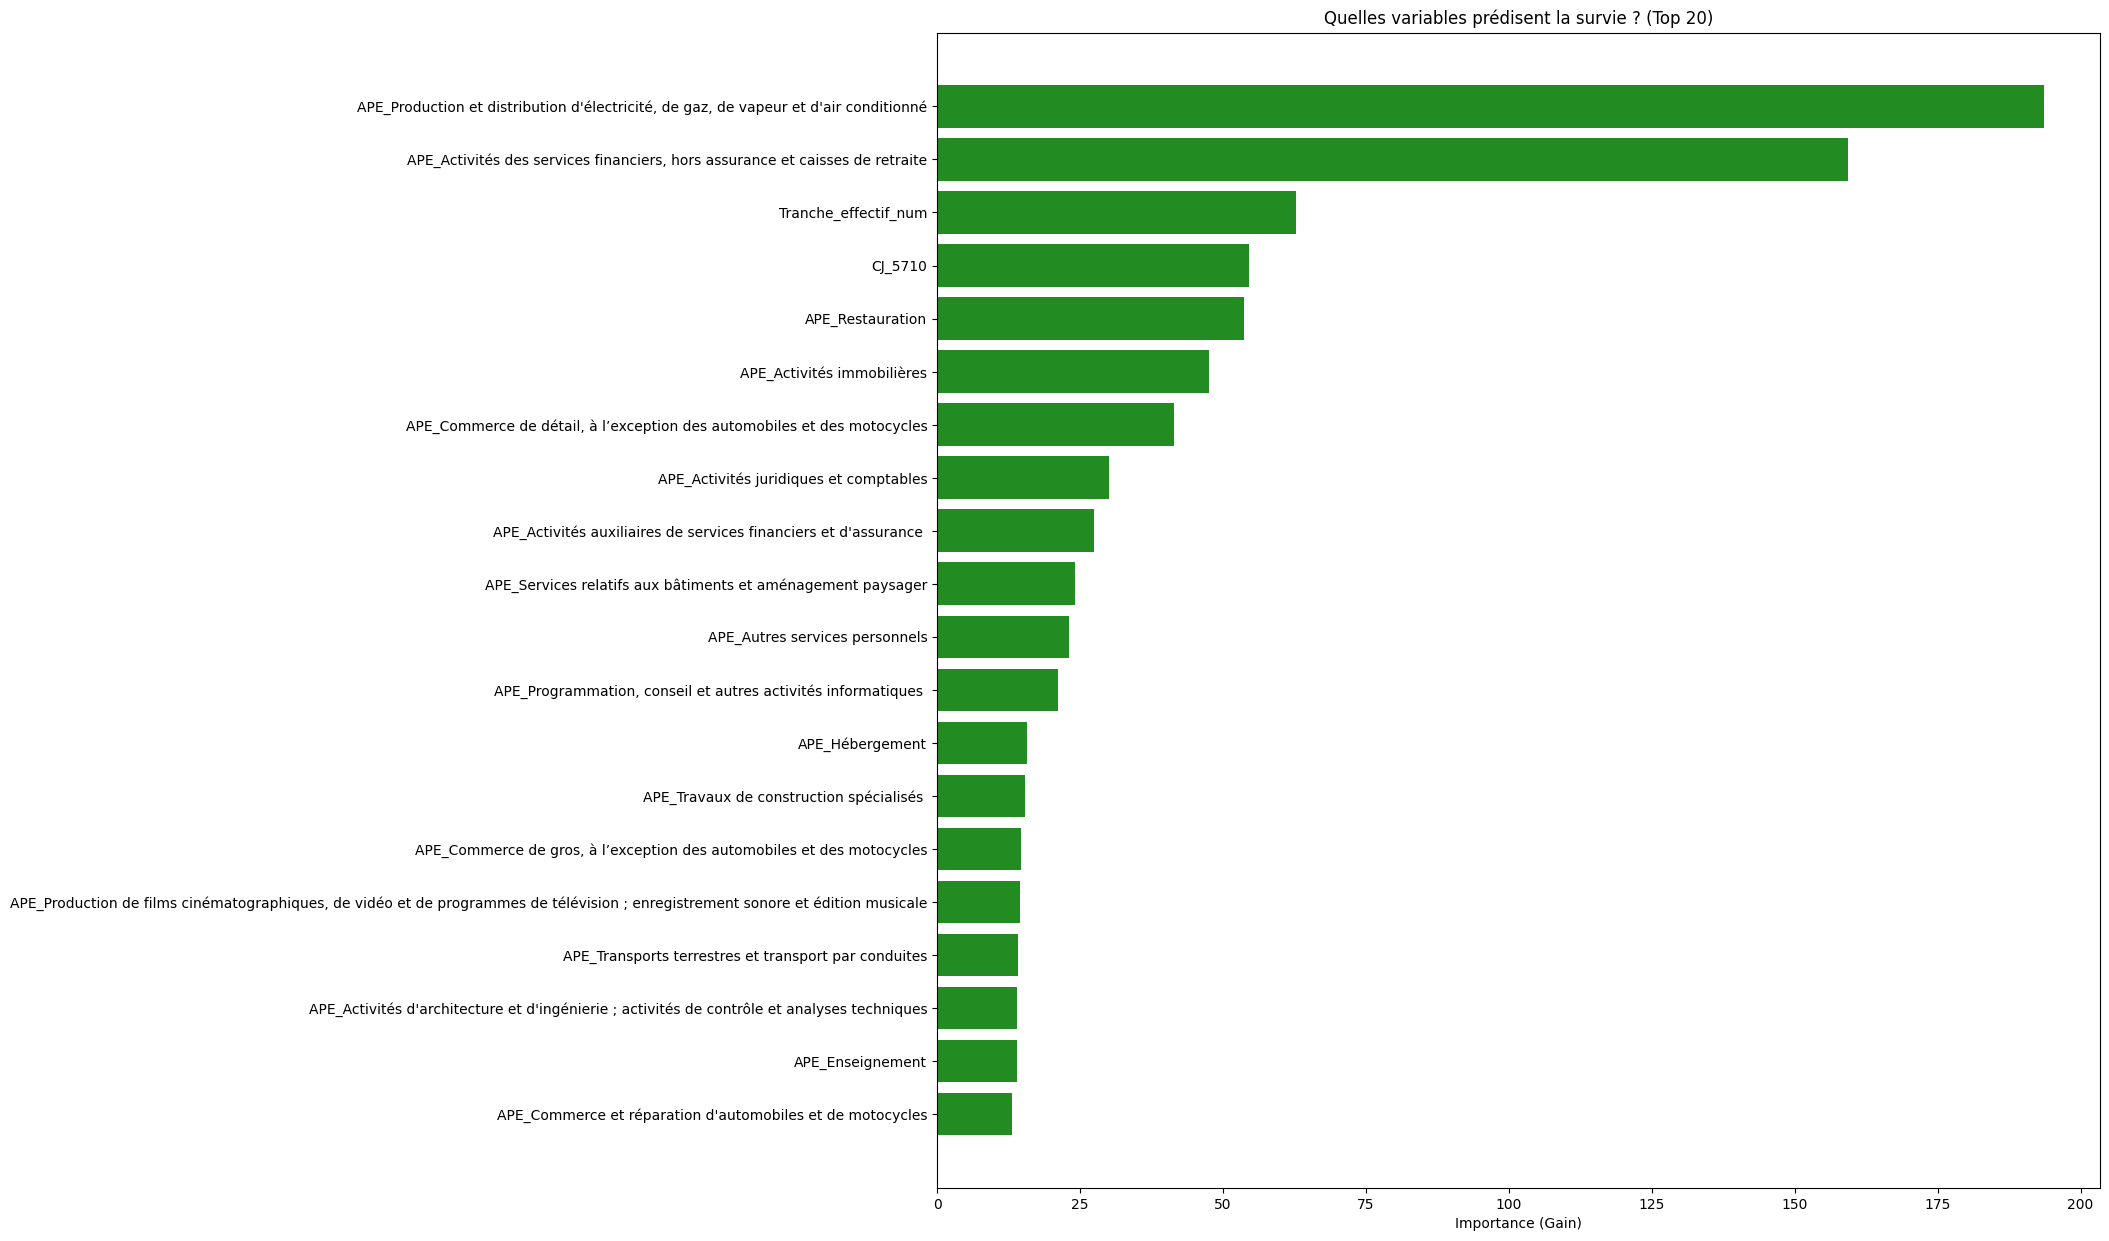

In [15]:
# On récupère l'importance basée sur le 'gain' 

importance = final_model.get_score(importance_type='gain')

# Tri et sélection des 20 meilleures
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]
labels, values = zip(*sorted_importance)

plt.figure(figsize=(15, 15))
plt.barh(range(len(labels)), values, color='forestgreen')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Importance (Gain)')
plt.title('Quelles variables prédisent la survie ? (Top 20)')
plt.gca().invert_yaxis()
plt.show()

---

#### Prédictions avec horizon temporel

In [ ]:
# 1. Prédire la durée de vie totale
preds_log_vie = final_model.predict(dtest)
preds_vie_totale = np.exp(preds_log_vie) 

# 2. Création du tableau de bord

df_forecast = pd.DataFrame({
    'age_actuel': y_test_time,
    'esperance_vie_totale': preds_vie_totale
}, index=X_test.index)

# 3. Calcul du temps restant avant la fermeture théortique
df_forecast['temps_restant_estime'] = df_forecast['esperance_vie_totale'] - df_forecast['age_actuel']

# 4. Calcul du risque par horizon

df_forecast['ferme_sous_1an'] = df_forecast['temps_restant_estime'] <= 1
df_forecast['ferme_sous_2ans'] = df_forecast['temps_restant_estime'] <= 2
df_forecast['ferme_sous_3ans'] = df_forecast['temps_restant_estime'] <= 3

# Nettoyage : On remplace les valeurs aberrantes (si le modèle prédit une mort déjà passée)
# par 0 pour le temps restant (alerte immédiate)
df_forecast['temps_restant_estime'] = df_forecast['temps_restant_estime'].clip(lower=0)

print("✅ Prévisions générées avec succès !")
display(df_forecast.head(10))

✅ Prévisions générées avec succès !


/tmp/ipykernel_5094/3499213046.py:6: RuntimeWarning:

overflow encountered in exp



,age_actuel,esperance_vie_totale,temps_restant_estime,ferme_sous_1an,ferme_sous_2ans,ferme_sous_3ans
164590,10.0000,5741.4771,5731.4771,False,False,False
1150125,2.0000,668.6652,666.6652,False,False,False
609753,12.0000,301599817728000.0000,301599817727988.0000,False,False,False
311670,3.0000,7991.4380,7988.4380,False,False,False
24536,29.0000,536404835010027146652493209927680.0000,536404835010027146652493209927680.0000,False,False,False
719529,19.0000,inf,inf,False,False,False
280998,3.0000,983.8944,980.8944,False,False,False
909083,7.0000,42169.6523,42162.6523,False,False,False
643710,9.0000,769153394886574080.0000,769153394886574080.0000,False,False,False
495743,4.0000,3093155249360945544538009467814412288.0000,3093155249360945544538009467814412288.0000,False,False,False


##### Ajustement des prédictions

In [ ]:
# 1. On récupère les prédictions brutes (les logs ou les valeurs infinies)
preds = final_model.predict(dtest)

# 2. On transforme ces prédictions en RANGS (0 à 1)
# Plus la prédiction de survie est BASSE, plus le RANG de risque est HAUT
# On utilise 'rank' pour ignorer les valeurs "inf" et se concentrer sur l'ordre
risk_score = pd.Series(preds).rank(pct=True, ascending=False)

# 3. Création du nouveau tableau de bord
df_results = pd.DataFrame({
    'age_actuel': y_test_time.values,
    'indice_risque': risk_score.values * 100
}, index=X_test.index)

# 4. Calibration des horizons (Basé sur la distribution statistique du risque)
# On définit des seuils de criticité
def evaluer_horizon(score):
    if score > 90: return True
    return False

df_results['alerte_immédiate_1an'] = df_results['indice_risque'] > 85
df_results['risque_modéré_2ans'] = df_results['indice_risque'] > 70
df_results['risque_3ans'] = df_results['indice_risque'] > 50

display(df_results.sort_values('indice_risque', ascending=False).head(10))

,age_actuel,indice_risque,alerte_immédiate_1an,risque_modéré_2ans,risque_3ans
776372,6.0000,100.0000,True,True,True
610659,11.0000,99.9994,True,True,True
794783,4.0000,99.9986,True,True,True
941649,2.0000,99.9986,True,True,True
799461,3.0000,99.9961,True,True,True
792520,4.0000,99.9961,True,True,True
709142,3.0000,99.9961,True,True,True
1021106,3.0000,99.9961,True,True,True
976901,4.0000,99.9961,True,True,True
477173,4.0000,99.9961,True,True,True


##### Définition des seuils d'alerte

In [ ]:
# 1. Prédiction brute du modèle
preds = final_model.predict(dtest)

# 2. Transformation en Indice de Risque (0 à 100)
# On transforme les prédictions en rangs : plus la prédiction de survie est basse, 
# plus l'indice de risque est proche de 100.
risk_score = pd.Series(preds).rank(pct=True, ascending=False) * 100

# 3. Construction du tableau de bord consolidé
# On récupère l'âge actuel et les informations de secteur/taille
df_final = pd.DataFrame({
    'age_actuel': y_test_time.values,
    'indice_risque': risk_score.values
}, index=X_test.index)

# 4. Attribution des alertes par horizon
# Ces seuils sont basés sur la distribution statistique du risque
df_final['alerte_1_an'] = df_final['indice_risque'] > 85  # Top 15% plus fragiles
df_final['alerte_2_ans'] = df_final['indice_risque'] > 70 # Top 30%
df_final['alerte_3_ans'] = df_final['indice_risque'] > 55 # Top 45%

# 5. Ajout d'une recommandation textuelle automatique
def generer_avis(row):
    if row['alerte_1_an']: return "🔴 CRITIQUE : Risque de fermeture imminent"
    if row['alerte_2_ans']: return "🟠 VIGILANCE : Fragilité à moyen terme"
    if row['alerte_3_ans']: return "🟡 OBSERVATION : Secteur/Profil instable"
    return "🟢 SAIN : Profil de survie solide"

df_final['avis_expert'] = df_final.apply(generer_avis, axis=1)

# Affichage des résultats
print("✅ Analyse de survie consolidée :")
display(df_final.sort_values('indice_risque', ascending=False).head(15))

✅ Analyse de survie consolidée :


,age_actuel,indice_risque,alerte_1_an,alerte_2_ans,alerte_3_ans,avis_expert
776372,6.0000,100.0000,True,True,True,🔴 CRITIQUE : Risque de fermeture imminent
610659,11.0000,99.9994,True,True,True,🔴 CRITIQUE : Risque de fermeture imminent
794783,4.0000,99.9986,True,True,True,🔴 CRITIQUE : Risque de fermeture imminent
941649,2.0000,99.9986,True,True,True,🔴 CRITIQUE : Risque de fermeture imminent
799461,3.0000,99.9961,True,True,True,🔴 CRITIQUE : Risque de fermeture imminent
...,...,...,...,...,...,...
836441,5.0000,99.9961,True,True,True,🔴 CRITIQUE : Risque de fermeture imminent
916185,7.0000,99.9933,True,True,True,🔴 CRITIQUE : Risque de fermeture imminent
218154,4.0000,99.9933,True,True,True,🔴 CRITIQUE : Risque de fermeture imminent
1136842,2.0000,99.9933,True,True,True,🔴 CRITIQUE : Risque de fermeture imminent


##### Définition des catégories de risques de fermeture

In [ ]:

# On crée des catégories de risque
df_results['Niveau_Risque'] = pd.cut(df_results['indice_risque'], 
                                     bins=[0, 50, 75, 90, 100], 
                                     labels=['Faible', 'Modéré', 'Élevé', 'Critique'])

fig = px.histogram(df_results, x="Niveau_Risque", 
                   color="Niveau_Risque",
                   title="Répartition du Risque de Fermeture (Portefeuille Test)",
                   color_discrete_map={'Critique':'#8B0000', 'Élevé':'#FF4500', 'Modéré':'#FFA500', 'Faible':'#2E8B57'})

fig.update_layout(xaxis_title="Catégorie de Risque (basée sur l'indice 0-100)", yaxis_title="Nombre d'entreprises")
fig.show()

##### Visus des secteurs les plus à risques

In [ ]:
# On fusionne les scores avec les noms de secteurs (APE)
top_risques = df_results[df_results['indice_risque'] > 90].join(X_test)
sectors_at_risk = top_risques[[col for col in X_test.columns if 'APE_' in col]].sum().sort_values(ascending=False).head(10)

print("🚨 Secteurs les plus représentés dans le top 10% de risque :")
print(sectors_at_risk)

🚨 Secteurs les plus représentés dans le top 10% de risque :
APE_Commerce de détail, à l’exception des automobiles et des motocycles    2495
APE_Travaux de construction spécialisés                                    2375
APE_Restauration                                                           2083
APE_Programmation, conseil et autres activités informatiques               2043
APE_Transports terrestres et transport par conduites                       1581
APE_Commerce et réparation d'automobiles et de motocycles                  1483
APE_Autres services personnels                                             1059
APE_Enseignement                                                           1015
APE_Commerce de gros, à l’exception des automobiles et des motocycles       920
APE_Services relatifs aux bâtiments et aménagement paysager                 582
dtype: int64


##### Détermination du risque final

In [ ]:
# 1. On crée un DataFrame avec les secteurs et les horizons
df_strat = df_results.join(X_test)

# 2. On groupe par secteur APE pour voir le % de risque à 1 et 3 ans

ape_cols = [col for col in X_test.columns if 'APE_' in col]
analyse_secteurs = []

for col in ape_cols:
    subset = df_strat[df_strat[col] == 1]
    if len(subset) > 100: 
        analyse_secteurs.append({
            'Secteur': col.replace('APE_', ''),
            'Volume': len(subset),
            'Risque_1an_%': subset['alerte_immédiate_1an'].mean() * 100,
            'Risque_2ans_%': subset['risque_modéré_2ans'].mean() * 100,
            'Risque_3ans_%': subset['risque_3ans'].mean() * 100,
        })

df_synthese = pd.DataFrame(analyse_secteurs)

# On calcule une colonne de tri intelligente : la moyenne pondérée du risque
df_synthese['Fragilité_Score'] = (df_synthese['Risque_1an_%'] + df_synthese['Risque_2ans_%'] + df_synthese['Risque_3ans_%']) / 3

df_synthese = df_synthese.sort_values('Risque_2ans_%', ascending=False)

print("📋 SYNTHÈSE STRATÉGIQUE COMPLÈTE (Horizons 1, 2 et 3 ans)")
display(df_synthese.head(10))

📋 SYNTHÈSE STRATÉGIQUE COMPLÈTE (Horizons 1, 2 et 3 ans)


,Secteur,Volume,Risque_1an_%,Risque_2ans_%,Risque_3ans_%,Fragilité_Score
43,Services d'information,710,45.4930,52.2535,65.7746,54.5070
7,Activités des sièges sociaux ; conseil de gestion,13090,5.0267,49.2895,57.5783,37.2982
45,Transports terrestres et transport par conduites,5866,40.8115,46.3007,72.1105,53.0742
25,Fabrication de boissons,249,9.6386,46.1847,63.0522,39.6252
37,"Programmation, conseil et autres activités inf...",5404,42.3020,45.1332,73.9267,53.7873
4,Activités de location et location-bail,2101,33.2699,45.0738,68.2056,48.8498
35,"Production de films cinématographiques, de vid...",1755,12.8775,44.2165,48.2051,35.0997
13,"Autres activités spécialisées, scientifiques e...",2716,17.8203,43.8144,70.7658,44.1335
0,Activités administratives et autres activités ...,3114,15.7354,43.8022,60.9827,40.1734
49,Édition,1088,19.7610,41.5441,47.2426,36.1826


##### Trajectoire du risque

In [ ]:
# On sélectionne le Top 5 des secteurs les plus fragiles (selon Fragilité_Score)
top_5_fragile = df_synthese.sort_values('Fragilité_Score', ascending=False).head(5)

fig = go.Figure()

for index, row in top_5_fragile.iterrows():
    fig.add_trace(go.Scatter(
        x=['1 an', '2 ans', '3 ans'],
        y=[row['Risque_1an_%'], row['Risque_2ans_%'], row['Risque_3ans_%']],
        mode='lines+markers',
        name=row['Secteur'],
        line=dict(width=3),
        marker=dict(size=10)
    ))

fig.update_layout(
    title="Trajectoire du risque : Évolution du % de fermeture prédit",
    xaxis_title="Horizon temporel",
    yaxis_title="% d'entreprises à risque",
    hovermode="x unified",
    template="plotly_white",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

---

#### Prédictions finales sur le dataset

In [ ]:
# --- 1. CALCUL DU RISQUE INDIVIDUEL ---
preds = final_model.predict(dtest)

risk_score = pd.Series(preds).rank(pct=True, ascending=False) * 100

# Création de la table de travail interne
df_work = pd.DataFrame({
    'idx': X_test.index,
    'risk': risk_score.values,
    'a1': (risk_score.values > 85),
    'a2': (risk_score.values > 70),
    'a3': (risk_score.values > 55)
}).set_index('idx').join(X_test)

# --- 2. AGRÉGATION PAR SECTEUR (SYNTHÈSE) ---
ape_cols = [col for col in X_test.columns if col.startswith('APE_')]
synthese_data = []

for col in ape_cols:
    subset = df_work[df_work[col] == 1]
    if len(subset) > 100:
        synthese_data.append({
            'Secteur': col.replace('APE_', ''),
            'Entreprises': len(subset),
            'Risque_1an_%': subset['a1'].mean() * 100,
            'Risque_2ans_%': subset['a2'].mean() * 100,
            'Risque_3ans_%': subset['a3'].mean() * 100
        })

# --- 3. AFFICHAGE FINAL ---
df_synthese = pd.DataFrame(synthese_data)

df_synthese['Fragilité_Score'] = df_synthese[['Risque_1an_%', 'Risque_2ans_%', 'Risque_3ans_%']].mean(axis=1)

print("📋 SYNTHÈSE STRATÉGIQUE DES RISQUES PAR SECTEUR")
display(df_synthese.sort_values('Risque_2ans_%', ascending=False).head(15))

📋 SYNTHÈSE STRATÉGIQUE DES RISQUES PAR SECTEUR


,Secteur,Entreprises,Risque_1an_%,Risque_2ans_%,Risque_3ans_%,Fragilité_Score
43,Services d'information,710,45.4930,52.2535,62.1127,53.2864
7,Activités des sièges sociaux ; conseil de gestion,13090,5.0267,49.2895,51.3293,35.2152
45,Transports terrestres et transport par conduites,5866,40.8115,46.3007,66.2803,51.1308
25,Fabrication de boissons,249,9.6386,46.1847,61.8474,39.2236
37,"Programmation, conseil et autres activités inf...",5404,42.3020,45.1332,67.8386,51.7580
...,...,...,...,...,...,...
22,Enseignement,3256,37.3771,41.0627,57.0639,45.1679
21,Enquêtes et sécurité,858,32.1678,36.0140,41.3753,36.5190
1,Activités auxiliaires de services financiers e...,4393,1.2975,35.9435,54.0860,30.4424
20,Construction de bâtiments,3795,15.4150,33.3333,44.5323,31.0935


#### Import du modèle pour vérification

In [ ]:
# # On crée une structure de modèle vide
# loaded_model_json = xgb.Booster()

# # On charge les poids sauvegardés
# loaded_model_json.load_model("champion_model_survie.json")

# print("✅ Modèle JSON réimporté !")

# # Test rapide de prédiction pour vérifier que ça tourne
# test_preds = loaded_model_json.predict(dtest)
# print(f"Aperçu des prédictions (JSON) : {test_preds[:5]}")

✅ Modèle JSON réimporté !
Aperçu des prédictions (JSON) : [ 8.655463  6.505232 33.339733  8.986117 75.362404]
